<a href="https://colab.research.google.com/github/alejandroariaszuluaga/analisis_senales/blob/main/tarea9_AISS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tarea 9 AISS**

## **Punto 1**

Clustering para compresión de imagen. La falta de la solución en alguno de los enunciados de esta tarea implicará una nota de 0.0 en este ejercicio. Considere la imagen a color imagen3.png. El objetivo de este ejercicio es poder comprimir la imagen de tal manera que pueda ser representada con tan solo 16 niveles de color utilizando algún algoritmo de clustering. Si lo desea, puede utilizar la rutina clusteringImageTarea9.m que tiene varios de los pasos listos para resolver este problema.

In [112]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from google.colab import files
from scipy.stats import multivariate_normal
import cv2
import math
from tqdm import tqdm

Una forma de cargar los archivos es usando `files.upload()`
Aquí se debe subir el archivo llamado `imagen3.png`

In [113]:
from google.colab import files
# files.upload()

Otra forma, la cual se puede usar si se tiene el archivo en Google drive en el directorio `/content/gdrive/MyDrive/ColabNotebooks/AISS/` es importándolos desde allí directamente.

In [114]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##**1.A**
Lea la imagen imagen3.png en RGB. Esta imagen corresponde a un arreglo de $600 \times 800 \times 3$. Asuma que cada pixel es una observación de 3 dimensiones, y genere una matrix $X$ de tamaño $480000 \times 3$, cuyas filas están asociadas a cada pixel.

(480000, 3)

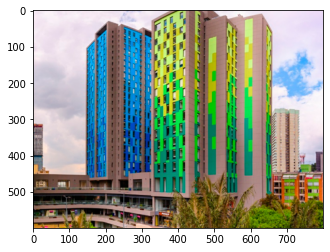

In [135]:
# Leer y organizar datos

# Read Images
img = mpimg.imread('/content/gdrive/MyDrive/Colab Notebooks/AISS/imagen3.png')
  
# Output Images
plt.imshow(img)


I = img/256 # Leer imagen
matriz_X = np.reshape(I,(I.shape[0]*I.shape[1],3)); # Vectorizar imagen
matriz_X.shape

## **1.B**

Grafique los puntos 3D en X utilizando la función de Matlab plot3 o su equivalente en Python. Esta es una representación de la imagen en el espacio RGB.

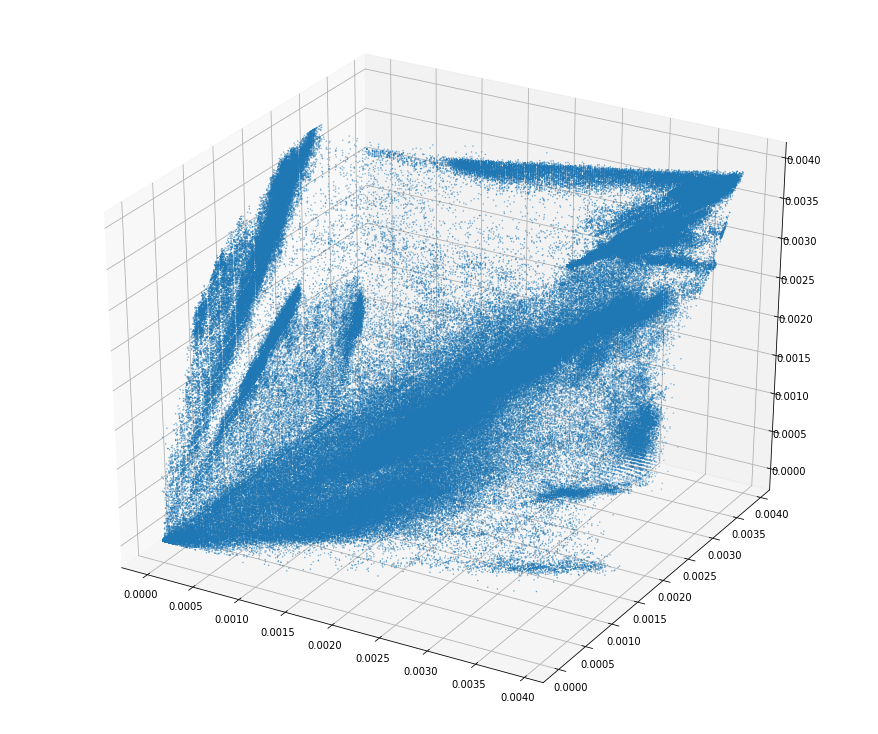

In [136]:
fig = plt.figure(figsize=(12,10))
ax = Axes3D(fig)

ax.scatter( matriz_X[:,0], matriz_X[:,1], matriz_X[:,2], s=0.18 )
plt.show()

## **1.C**

Utilizando el algoritmo EM para combinación de Gaussianas ya implementado en tareas anteriores (no puede utilizar funciones predefinidas para esto), encuentre K = 16 gaussianas para representar los datos en X y la pertenencia de cada uno de los 480000 datos a estas distribuciones. Grafique de nuevo
los puntos 3D en X como en el enunciado en a), pero ahora marque claramente la posición de las medias de las 16 Gaussianas, y pinte los datos con algún código de colores que permita identificar la pertenencia de los datos a las distribuciones Gaussianas.

### Algoritmo EM

In [147]:
muestras = np.copy(matriz_X)

In [148]:
def cov_gauss(XYZ,mu):
  suma = np.zeros([3,3])
  for i in range(len(XYZ)):
    t = XYZ[i]-mu
    prod = np.array([[t[0]**2,t[0]*t[1],t[0]*t[2]], [t[1]*t[0],t[1]**2,t[1]*t[2]], [t[2]*t[0],t[2]*t[1],t[2]**2]])
    suma += prod
  return (1/len(XYZ))*suma


In [149]:
mu_x = sum(muestras[:,0])/len(muestras)
mu_y = sum(muestras[:,1])/len(muestras)
mu_z = sum(muestras[:,2])/len(muestras)

mu_xyz = np.array([mu_x,mu_y,mu_z])
cov_xyz = cov_gauss(muestras,mu_xyz)

In [150]:
print(mu_xyz)
print(cov_xyz)

[0.00208279 0.00222443 0.00195545]
[[1.56385457e-06 7.89007298e-07 8.15988526e-07]
 [7.89007298e-07 9.08500042e-07 8.45697140e-07]
 [8.15988526e-07 8.45697140e-07 1.50014269e-06]]


In [151]:
def pdf_img(x,y,z,C_Z,mu_Z):
  z = np.array([x,y,z])
  p = ( 1 / ( 2 * np.pi * np.linalg.det(C_Z)**(1/2) ) ) * np.exp( - ( (np.transpose(z-mu_Z)).dot( np.linalg.inv(C_Z) ).dot( z-mu_Z ) ) / 2 )
  return p

In [152]:
x = np.linspace(0, 1, 40)
y = np.linspace(0, 1, 40)
z = np.linspace(0, 1, 40)

# Creación de una matriz que combina los valores del rango de X y Y
X,Y,Z = np.meshgrid(x, y, z)

# Los valores de la PDF se guardarán en la siguiente matriz
pdf_xyz = np.zeros( (len(X[0]), len(Y[0]), len(Z[0]) ) )

# Se evalúa la función definida anteriormente en cada uno de los puntos
for i in range(len(X[0])):
  for j in range(len(Y[0])):
    for k in range(len(Z[0])):
      pdf_xyz[i,j] = pdf_img(X[i,j,k],Y[i,j,k],Z[i,j,k],cov_xyz,mu_xyz)

### Superficies de Nivel (aún no se pueden graficar)

In [123]:
# fig = plt.figure()
# ax = plt.axes(projection='3d')
# ax.contour3D(X, Y, Z, 50, cmap='binary')
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('z')
# ax.set_title('3D contour')
# plt.show()

# # Se grafican las curvas de nivel de la función definida
# plt.figure(figsize=(8,5))
# contours = plt.contour3D(X, Y, Z)
# plt.clabel(contours, inline=1, fontsize=10)
# # Se grafican los datos reales
# # plt.scatter(muestras[:,0], muestras[:,1])
# # Accesorios de la figura
# plt.title('Curvas de Nivel PDF vs. Datos')
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.show()

### Algoritmo EM

In [153]:
def func_obj(XYZ,alpha,mu,cov):
  s1 = 0
  for i in range(len(XYZ)):
    s2 = 0
    for j in range(len(alpha)):
      s2 += alpha[j]*pdf_img( XYZ[i][0],XYZ[i][1],XYZ[i][2],cov[j],mu[j] )
    s1 += np.log(s2)
  return s1

def func_gamma(XYZ,alpha,mu,cov,k):
  suma = 0
  for i in range(len(alpha)):
    suma += alpha[i]*pdf_img(XYZ[0],XYZ[1],XYZ[2],cov[i],mu[i])
  return alpha[k]*pdf_img(XYZ[0],XYZ[1],XYZ[2],cov[k],mu[k])/suma

def func_muk(XYZ,gamma,Nk,k):
  s = np.zeros(3)
  for i in range(len(XYZ)):
    s += gamma[k][i]*XYZ[i]
  return s/Nk

def func_covk(XYZ,mu,gamma,Nk,k):
  suma = np.zeros([3,3])
  for i in range(len(XYZ)):
    t = XYZ[i]-mu[k]
    prod = np.array([[t[0]**2,t[0]*t[1],t[0]*t[2]], [t[1]*t[0],t[1]**2,t[1]*t[2]], [t[2]*t[0],t[2]*t[1],t[2]**2]])
    suma += prod*gamma[k][i]
  suma = suma/Nk
  return suma

In [154]:
def algoritmo_EM(XYZ,alpha_0,cov_0,mu_0):
  alpha = alpha_0
  cov = cov_0
  mu = mu_0
  
  alpha_acum = [alpha]
  cov_acum = [cov]
  mu_acum = [mu]

  func_max = func_obj(XYZ,alpha,mu,cov)
  cond1 = True
  cond2 = 0
  while cond1 and (cond2<15):
    print(f'Iteration {cond2} for EM algorithm')
    # try:
    # E-Step
    gamma = np.zeros((len(alpha),len(XYZ)))
    for i in range(len(alpha)):
      for j in range(len(XYZ)):
        gamma[i][j] = func_gamma(XYZ[j],alpha,mu,cov,i)
    
    # M-Step
    # Estimado N_k
    N_k = np.zeros(len(alpha))
    for i in range(len(alpha)):
      N_k[i] = sum(gamma[i])

    # Estimado mu_k
    mu_k = np.zeros((len(alpha),3))
    for i in range(len(alpha)):
      mu_k[i] = func_muk(XYZ,gamma,N_k[i],i)
    
    # Estimando a_k
    a_k = N_k/len(XYZ)
    # Estimando C_k
    C_k = np.zeros((len(alpha),3,3))
    for i in range(len(alpha)):
      C_k[i] = func_covk(XYZ,mu,gamma,N_k[i],i)

    # Actualización de los parámetros
    alpha = a_k
    mu = mu_k
    cov = C_k

    alpha_acum.append(alpha)
    cov_acum.append(cov)
    mu_acum.append(mu)
    
    # Evalua la condicion para parar el ciclo
    f = func_obj(XYZ,alpha,mu,cov)
    cond1 = abs(func_max - f) > 0.001
    cond2 += 1
    func_max = f
  # except Exception as e:
    print(cond2)
    # print(f'Something happened because {e}, will break cycle')
  print(f'Did {cond2} iterations')
  return alpha_acum,cov_acum,mu_acum

In [ ]:
# Condiciones iniciales
mu_0 = np.array([1,1,1])
C_Z0 = np.array([[1,0,0],[0,1,0],[0,0,1]])

alpha = np.random.random(16)
cov = np.array([C_Z0, 1.2*C_Z0, 1.5*C_Z0, 1.7*C_Z0, 2.1*C_Z0, 2.3*C_Z0, 1.4*C_Z0, 1.9*C_Z0, 2.0*C_Z0, 1.3*C_Z0, 2.4*C_Z0, 1.4*C_Z0, 1.5*C_Z0, 2.6*C_Z0, 2.1*C_Z0, 1.3*C_Z0])
mu = np.array([mu_0, 1.3*mu_0, mu_0, 1.2*mu_0, 2.1*mu_0, 1.4*mu_0, 1.5*mu_0, 1.7*mu_0, 1.9*mu_0, 2.1*mu_0, 2.3*mu_0, 1.3*mu_0, 2.4*mu_0, 1.3*mu_0, 2*mu_0, 2*mu_0])
alpha_acum_16G, cov_acum_16G, mu_acum_16G = algoritmo_EM(muestras,alpha,cov,mu)

Iteration 0 for EM algorithm


## **<----- CORRER HASTA AQUÍ**

In [ ]:
# Los valores de la PDF se guardarán en la siguiente matriz
Z_16G1 = np.zeros( (len(X[0]), len(Y[0])) )
Z_16G2 = np.copy(Z_16G1)
Z_16G3 = np.copy(Z_4G1)
Z_16G4 = np.copy(Z_4G1)

iter_3G = len(alpha_acum_3G)
iter_4G = len(alpha_acum_4G)

# Se evalúa la función definida anteriormente en cada uno de los puntos
for i in range(len(X[0])):
  for j in range(len(Y[0])):    
    ## Para cuatro distintas iteraciones de EM de 3 gaussianas
    p1 = alpha_acum_3G[1][0]*pdf_z(X[i,j],Y[i,j],cov_acum_3G[1][0],mu_acum_3G[1][0])
    p2 = alpha_acum_3G[1][1]*pdf_z(X[i,j],Y[i,j],cov_acum_3G[1][1],mu_acum_3G[1][1])
    p3 = alpha_acum_3G[1][2]*pdf_z(X[i,j],Y[i,j],cov_acum_3G[1][2],mu_acum_3G[1][2])
    Z_3G1[i,j] = p1 + p2 + p3
    p1 = alpha_acum_3G[iter_3G//3][0]*pdf_z(X[i,j],Y[i,j],cov_acum_3G[iter_3G//3][0],mu_acum_3G[iter_3G//3][0])
    p2 = alpha_acum_3G[iter_3G//3][1]*pdf_z(X[i,j],Y[i,j],cov_acum_3G[iter_3G//3][1],mu_acum_3G[iter_3G//3][1])
    p3 = alpha_acum_3G[iter_3G//3][2]*pdf_z(X[i,j],Y[i,j],cov_acum_3G[iter_3G//3][2],mu_acum_3G[iter_3G//3][2])
    Z_3G2[i,j] = p1 + p2 + p3
    p1 = alpha_acum_3G[2*iter_3G//3][0]*pdf_z(X[i,j],Y[i,j],cov_acum_3G[2*iter_3G//3][0],mu_acum_3G[2*iter_3G//3][0])
    p2 = alpha_acum_3G[2*iter_3G//3][1]*pdf_z(X[i,j],Y[i,j],cov_acum_3G[2*iter_3G//3][1],mu_acum_3G[2*iter_3G//3][1])
    p3 = alpha_acum_3G[2*iter_3G//3][2]*pdf_z(X[i,j],Y[i,j],cov_acum_3G[2*iter_3G//3][2],mu_acum_3G[2*iter_3G//3][2])
    Z_3G3[i,j] = p1 + p2 + p3
    p1 = alpha_acum_3G[-1][0]*pdf_z(X[i,j],Y[i,j],cov_acum_3G[-1][0],mu_acum_3G[-1][0])
    p2 = alpha_acum_3G[-1][1]*pdf_z(X[i,j],Y[i,j],cov_acum_3G[-1][1],mu_acum_3G[-1][1])
    p3 = alpha_acum_3G[-1][2]*pdf_z(X[i,j],Y[i,j],cov_acum_3G[-1][2],mu_acum_3G[-1][2])
    Z_3G4[i,j] = p1 + p2 + p3

    ## Para cuatro distintas iteraciones de EM de 4 gaussianas
    p1 = alpha_acum_4G[1][0]*pdf_z(X[i,j],Y[i,j],cov_acum_4G[1][0],mu_acum_4G[1][0])
    p2 = alpha_acum_4G[1][1]*pdf_z(X[i,j],Y[i,j],cov_acum_4G[1][1],mu_acum_4G[1][1])
    p3 = alpha_acum_4G[1][2]*pdf_z(X[i,j],Y[i,j],cov_acum_4G[1][2],mu_acum_4G[1][2])
    p4 = alpha_acum_4G[1][3]*pdf_z(X[i,j],Y[i,j],cov_acum_4G[1][3],mu_acum_4G[1][3])
    Z_4G1[i,j] = p1 + p2 + p3 + p4
    p1 = alpha_acum_4G[iter_4G//3][0]*pdf_z(X[i,j],Y[i,j],cov_acum_4G[iter_4G//3][0],mu_acum_4G[iter_4G//3][0])
    p2 = alpha_acum_4G[iter_4G//3][1]*pdf_z(X[i,j],Y[i,j],cov_acum_4G[iter_4G//3][1],mu_acum_4G[iter_4G//3][1])
    p3 = alpha_acum_4G[iter_4G//3][2]*pdf_z(X[i,j],Y[i,j],cov_acum_4G[iter_4G//3][2],mu_acum_4G[iter_4G//3][2])
    p4 = alpha_acum_4G[iter_4G//3][3]*pdf_z(X[i,j],Y[i,j],cov_acum_4G[iter_4G//3][3],mu_acum_4G[iter_4G//3][3])
    Z_4G2[i,j] = p1 + p2 + p3 + p4
    p1 = alpha_acum_4G[2*iter_4G//3][0]*pdf_z(X[i,j],Y[i,j],cov_acum_4G[2*iter_4G//3][0],mu_acum_4G[2*iter_4G//3][0])
    p2 = alpha_acum_4G[2*iter_4G//3][1]*pdf_z(X[i,j],Y[i,j],cov_acum_4G[2*iter_4G//3][1],mu_acum_4G[2*iter_4G//3][1])
    p3 = alpha_acum_4G[2*iter_4G//3][2]*pdf_z(X[i,j],Y[i,j],cov_acum_4G[2*iter_4G//3][2],mu_acum_4G[2*iter_4G//3][2])
    p4 = alpha_acum_4G[2*iter_4G//3][3]*pdf_z(X[i,j],Y[i,j],cov_acum_4G[2*iter_4G//3][3],mu_acum_4G[2*iter_4G//3][3])
    Z_4G3[i,j] = p1 + p2 + p3 + p4
    p1 = alpha_acum_4G[-1][0]*pdf_z(X[i,j],Y[i,j],cov_acum_4G[-1][0],mu_acum_4G[-1][0])
    p2 = alpha_acum_4G[-1][1]*pdf_z(X[i,j],Y[i,j],cov_acum_4G[-1][1],mu_acum_4G[-1][1])
    p3 = alpha_acum_4G[-1][2]*pdf_z(X[i,j],Y[i,j],cov_acum_4G[-1][2],mu_acum_4G[-1][2])
    p4 = alpha_acum_4G[-1][3]*pdf_z(X[i,j],Y[i,j],cov_acum_4G[-1][3],mu_acum_4G[-1][3])
    Z_4G4[i,j] = p1 + p2 + p3 + p4

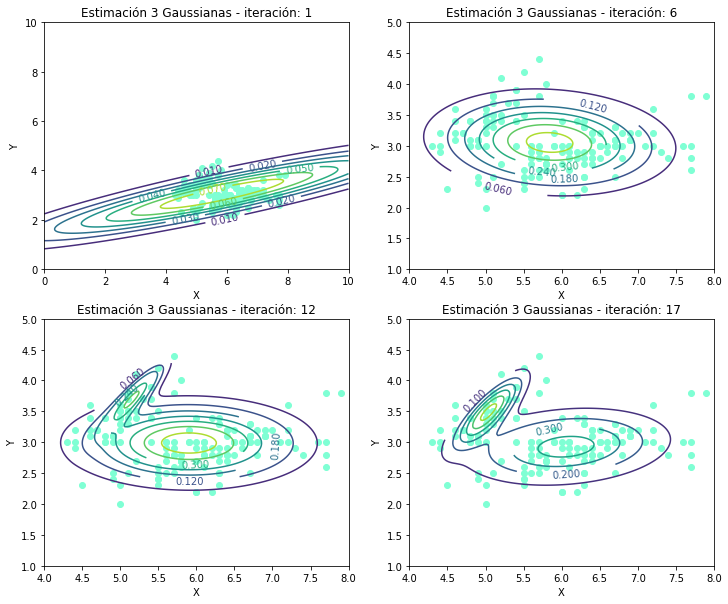

In [ ]:
# Se grafican las curvas de nivel de la función definida
plt.figure(figsize=(12,10))
plt.subplot(221)
contours = plt.contour(X, Y, Z_3G1)
plt.clabel(contours, inline=1, fontsize=10)
# Se grafican los datos reales
plt.scatter(muestras[:,0], muestras[:,1], color='aquamarine')
# Accesorios de la figura
plt.title('Estimación 3 Gaussianas - iteración: 1')
plt.xlabel('X')
plt.ylabel('Y')

plt.subplot(222)
contours = plt.contour(X, Y, Z_3G2)
plt.clabel(contours, inline=1, fontsize=10)
# Se grafican los datos reales
plt.scatter(muestras[:,0], muestras[:,1], color='aquamarine')
# Accesorios de la figura
plt.title('Estimación 3 Gaussianas - iteración: ' + str(iter_3G//3))
plt.xlim(left=4, right=8)
plt.ylim(bottom=1, top=5)
plt.xlabel('X')
plt.ylabel('Y')

plt.subplot(223)
contours = plt.contour(X, Y, Z_3G3)
plt.clabel(contours, inline=1, fontsize=10)
# Se grafican los datos reales
plt.scatter(muestras[:,0], muestras[:,1], color='aquamarine')
plt.xlim(left=4, right=8)
plt.ylim(bottom=1, top=5)
# Accesorios de la figura
plt.title('Estimación 3 Gaussianas - iteración: ' + str(2*iter_3G//3))
plt.xlabel('X')
plt.ylabel('Y')

plt.subplot(224)
contours = plt.contour(X, Y, Z_3G4)
plt.clabel(contours, inline=1, fontsize=10)
# Se grafican los datos reales
plt.scatter(muestras[:,0], muestras[:,1], color='aquamarine')
plt.xlim(left=4, right=8)
plt.ylim(bottom=1, top=5)
# Accesorios de la figura
plt.title('Estimación 3 Gaussianas - iteración: ' + str(iter_3G-1))
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

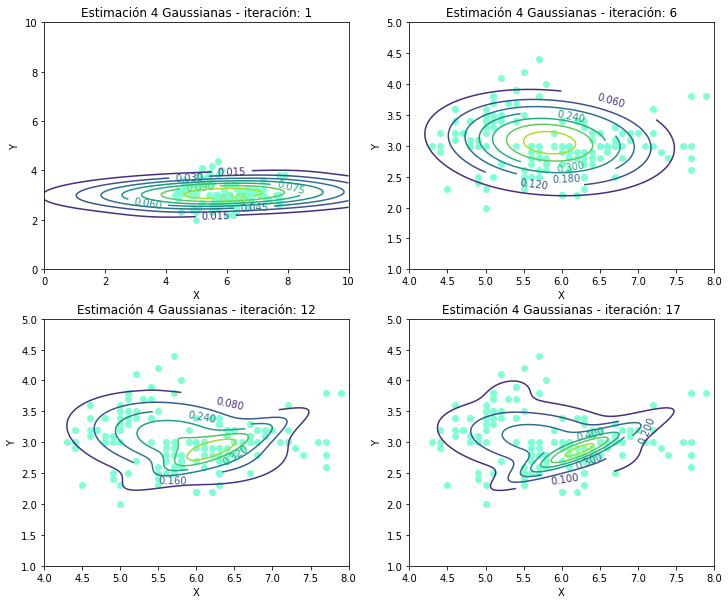

In [ ]:
# Se grafican las curvas de nivel de la función definida
plt.figure(figsize=(12,10))
plt.subplot(221)
contours = plt.contour(X, Y, Z_4G1)
plt.clabel(contours, inline=1, fontsize=10)
# Se grafican los datos reales
plt.scatter(muestras[:,0], muestras[:,1], color='aquamarine')
# Accesorios de la figura
plt.title('Estimación 4 Gaussianas - iteración: 1')
plt.xlabel('X')
plt.ylabel('Y')

plt.subplot(222)
contours = plt.contour(X, Y, Z_4G2)
plt.clabel(contours, inline=1, fontsize=10)
# Se grafican los datos reales
plt.scatter(muestras[:,0], muestras[:,1], color='aquamarine')
plt.xlim(left=4, right=8)
plt.ylim(bottom=1, top=5)
# Accesorios de la figura
plt.title('Estimación 4 Gaussianas - iteración: ' + str(iter_3G//3))
plt.xlabel('X')
plt.ylabel('Y')

plt.subplot(223)
contours = plt.contour(X, Y, Z_4G3)
plt.clabel(contours, inline=1, fontsize=10)
# Se grafican los datos reales
plt.scatter(muestras[:,0], muestras[:,1], color='aquamarine')
plt.xlim(left=4, right=8)
plt.ylim(bottom=1, top=5)
# Accesorios de la figura
plt.title('Estimación 4 Gaussianas - iteración: ' + str(2*iter_4G//3))
plt.xlabel('X')
plt.ylabel('Y')

plt.subplot(224)
contours = plt.contour(X, Y, Z_4G4)
plt.clabel(contours, inline=1, fontsize=10)
# Se grafican los datos reales
plt.scatter(muestras[:,0], muestras[:,1], color='aquamarine')
plt.xlim(left=4, right=8)
plt.ylim(bottom=1, top=5)
# Accesorios de la figura
plt.title('Estimación 4 Gaussianas - iteración: ' + str(iter_4G-1))
plt.xlabel('X')
plt.ylabel('Y')
plt.show()